In [84]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [85]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [99]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, extract, and_, desc

In [77]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [78]:
# reflect an existing database into a new model
Base= automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)

In [79]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [80]:
# Save references to each table
Measurement = Base.classes.measurement
Station= Base.classes.station

In [81]:
# Create our session (link) from Python to the DB
session= Session(engine)

# Exploratory Climate Analysis

Text(0, 0.5, 'Inches')

Text(0.5, 0, 'Date')

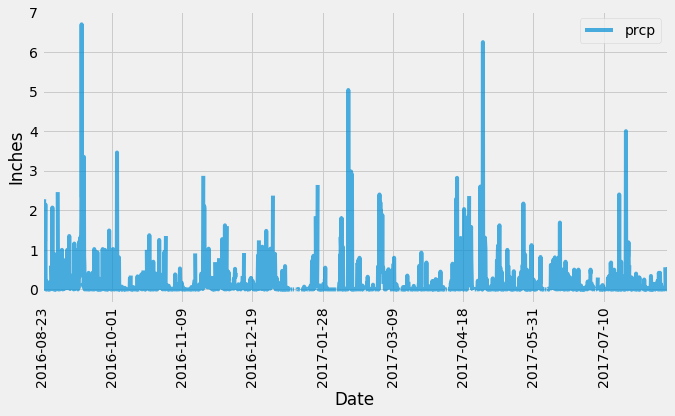

<Figure size 432x288 with 0 Axes>

In [87]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
stmt = session.query(Measurement.date, Measurement.prcp).\
        filter(and_(Measurement.date > '2016-08-22')) 
#                (Measurement.prcp!=None))

df = pd.read_sql_query(stmt.statement, session.bind)
df.set_index('date', inplace=True)
df.sort_values('date', inplace = True)


df_plot= df.plot(figsize=(10,5), rot=90, alpha=0.7)
df_plot.set_ylabel('Inches')
df_plot.set_xlabel('Date')
plt.show()
plt.tight_layout()

In [92]:
# Query the last date
last_date= session.query(Measurement.date).\
            order_by(Measurement.date.desc()).first()[0]
print(f'Last date {last_date} in the dataset.')

Last date 2017-08-23 in the dataset.


In [93]:
# Calculate the date 1 year ago from the last data point in the database
req_date= dt.date(2017, 8, 23) - dt.timedelta(days=365)

print(req_date)

2016-08-23


In [94]:
# Summary statistics for the precipitation data.
print(df.describe())

              prcp
count  2021.000000
mean      0.177279
std       0.461190
min       0.000000
25%       0.000000
50%       0.020000
75%       0.130000
max       6.700000


Text(0, 0.5, 'Inches')

Text(0.5, 0, 'Date')

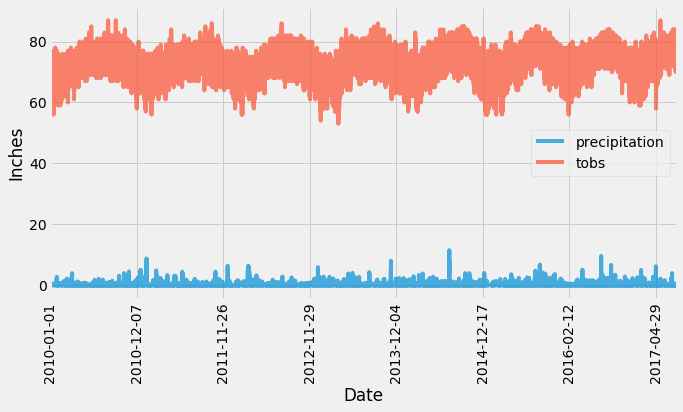

<Figure size 432x288 with 0 Axes>

In [95]:
# Perform a query to retrieve the data and precipitation scores
result= session.query(Measurement).\
        filter((Measurement.prcp)!=None)

# Save the query results as a Pandas DataFrame and set the index to the date column
res= pd.read_sql_query(result.statement, session.bind)
res.set_index('date', inplace= True)

# Sort the dataframe by date
res.sort_values('date', inplace= True)

# Use Pandas Plotting with Matplotlib to plot the data
res= res.rename(columns={'prcp': 'precipitation'})
ax= res[['precipitation', 'tobs']].plot(figsize=(10,5), rot=90, alpha=0.7)
ax.set_ylabel('Inches')
ax.set_xlabel('Date')
plt.show()
plt.tight_layout()

In [96]:
# Use Pandas to calcualte the summary statistics for the precipitation data
print(res['precipitation'].describe())

count    18103.000000
mean         0.160644
std          0.468746
min          0.000000
25%          0.000000
50%          0.010000
75%          0.110000
max         11.530000
Name: precipitation, dtype: float64


In [97]:
# Design a query to show how many stations are available in this dataset?
Total_stations_unique= session.query(Measurement.station).distinct().count()
print(f'There are {Total_stations_unique} unique stations available in this dataset')

There are 9 unique stations available in this dataset


In [100]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

sta_freq= session.query(Measurement.id, func.count(Measurement.station).\
          label('Nos'),Measurement.station).group_by(Measurement.station).\
          order_by(desc('Nos'))
for station in sta_freq:
    print(station)


(12188, 2772, 'USC00519281')
(1, 2724, 'USC00519397')
(2725, 2709, 'USC00513117')
(9519, 2669, 'USC00519523')
(16939, 2612, 'USC00516128')
(5434, 2202, 'USC00514830')
(14960, 1979, 'USC00511918')
(7636, 1372, 'USC00517948')
(9008, 511, 'USC00518838')


In [101]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
low_temp= session.query(func.min(Measurement.tobs)).\
          filter(Measurement.station=='USC00519281')
max_temp= session.query(func.max(Measurement.tobs)).\
          filter(Measurement.station == 'USC00519281')
average_temp= session.query(func.avg(Measurement.tobs)).\
          filter(Measurement.station=='USC00519281')
min_temp= []
high_temp= []
avg_temp= []
for blue in low_temp:
    if blue is not None:
        min_temp.append(blue)
for red in max_temp:
    if red is not None:
        high_temp.append(red)
for orange in average_temp:
    if orange is not None:
        avg_temp.append(orange)

print(f'Minimum temp. is {list(np.ravel(min_temp))},\
 Average temp. is {list(np.ravel(avg_temp))},\
 High temp. is {list(np.ravel(high_temp))}')

Minimum temp. is [54.0], Average temp. is [71.66378066378067], High temp. is [85.0]


(array([ 5.,  7.,  7., 12., 27., 41., 40., 57., 66., 53., 29.,  8.]),
 array([59., 61., 63., 65., 67., 69., 71., 73., 75., 77., 79., 81., 83.]),
 <a list of 12 Patch objects>)

Text(0.5, 0, 'Temperature')

Text(0, 0.5, 'Frequency')

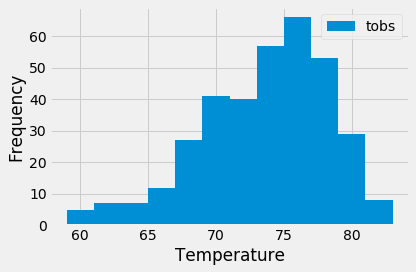

In [102]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
records= session.query(Measurement.date, Measurement.tobs).\
        filter(and_(Measurement.date>='2016-08-23'),
               (Measurement.station=='USC00519281')).\
                group_by(Measurement.date)
df_records= pd.read_sql_query(records.statement, session.bind)
df_records.sort_values('date', inplace=True)
df_records.set_index('date', inplace= True)

plt.hist(df_records['tobs'], bins=12, label=['tobs'])
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()


## Bonus Challenge Assignment

In [103]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [108]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date= '2017-03-01'
end_date= '2017-03-14'
a= list(np.ravel(calc_temps(start_date, end_date)))
print(a)

[62.0, 71.03488372093024, 82.0]


<BarContainer object of 3 artists>

Text(0, 0.5, 'Temp(F)')

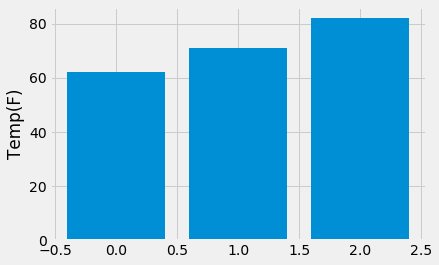

In [114]:
# Plot the results from your previous query as a bar chart. 
b= ['TMIN', 'TAVE', 'TMAX']
y_pos = np.arange(len(b))
plt.bar(y_pos, a)
plt.ylabel('Temp(F)')
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [115]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
